# Predicting Early Prediction of Patient MET call at the time of admission


## Table of Contents

* [1. __Prepare Problem__](#heading--1)
  * [1.1. Load libraries](#heading--1-1)
  * [1.2. Load dataset](#heading--1-2)
  * [1.3. Describe the data](#heading--1-3)
  * [1.4. Imbalanced dataset](#heading--1-4)
* [2. __Data preparation__](#heading--2)
  * [2.1. Data cleanup](#heading--2-I)
  * [2.2. Feature Selection](#heading--2-II)
* [3. __Imbalanced Classification__](#heading--III)
  * [3.1. Model comparison](#heading--3-I)
  * [3.2. Hyperparameter Tuning](#heading--3-II)

<a class="anchor" id="heading--1"></a>
## 1. __Prepare Problem__


<a class="anchor" id="heading--1-1"></a>
## 1.1. __Load libraries__

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
import glob
import os
import gc
##from data_prepare                  import data_prep
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import pandas                      as pd
from utils.utils                   import make_confusion_matrix,groupby_,PRC_models,gc_models
from tqdm.notebook                 import tqdm # progressbar
from time                          import sleep
from imblearn.under_sampling       import InstanceHardnessThreshold
from imblearn.pipeline             import Pipeline
from imblearn.pipeline             import make_pipeline
from imblearn.ensemble             import BalancedBaggingClassifier
from imblearn.ensemble             import BalancedRandomForestClassifier
from imblearn.ensemble             import EasyEnsembleClassifier

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedStratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.model_selection       import GridSearchCV
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import recall_score
from sklearn.metrics               import make_scorer
from sklearn.metrics               import fbeta_score
from sklearn.linear_model          import LogisticRegression 
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.naive_bayes           import ComplementNB
from sklearn.utils.class_weight    import compute_class_weight
from sklearn.svm                   import SVC
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import chi2
from sklearn.feature_selection     import RFE
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.compose               import ColumnTransformer
from category_encoders             import MEstimateEncoder


from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.reset_option('all')
%matplotlib inline
data_path = '../../data_2021-may-15/'

# separate X and Y
CM_labels = ['True Neg','False Pos','False Neg','True Pos']
CM_categories = ['Zero', 'One']

# name of dependant variable
target = 'anycall'


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



<a class="anchor" id="heading--1-2"></a>
### 1.2. __Load dataset__

In [2]:
# load @admission file based on 1~167 csv files 
df =  pd.read_csv(data_path+'@admission_allData.csv', low_memory=False)
print('Dataset loaded successfully.\nDimensions of the dataset: {}'.format(df.shape))


Dataset loaded successfully.
Dimensions of the dataset: (163273, 145)


<div id="heading--1-3"/>

### 1.3. __Describe the data__

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.head(2))

,Unnamed: 0,dt,visit,urno,age,sex,indig,cadttext,cward,cbed,cunit,csource,cadmitclass,cpvthlth,cadmitmbs,cexpstay,evisit,ecomplaintcode,ecomplaint,etriage,cicu,ctheatre,pvisit,padmdtext,punit,plos,pcomorbid,ageadmission,agerisk,combinedscore,survive10,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,pdiagd,pproc,pprocd,pcall,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,postcode,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,atrisk,id,frailty,rdt,cadt,padt,sequence,outcome,wies,drg,icd10,diagnosis,dobt,dodt,admitdt,adt,ad,dischargedt,ddt,dd,died,dob,dod,call,eventdate,met,cb,arrest,anycall,hiout,anyarrest,charlsum,charl2,edvisit,ipany,edany,period,sequencelos,phc,bicarbc,lactatec,hbc,wccc,creatininec,plateletsc,phc2,bicarbc2,lactatec2,hbc2,wccc2,creatininec2,plateletsc2,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,elective2,outlier,frail3,frail2
0,0.0,2019-07-23 15:01:37,897520,1226958.0,72.845990,F,0,2019-07-23 14:53:09,MTC,,N/L,HME,EAD,0,,0,NaN,NaN,NaN,NaN,0,0,8342444.0,2018-05-22 00:00:00,GAS,0,1.0,71.0,3.0,4.0,0.534,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,R19.5,Other faecal abnormalities,32090-00,Fibreoptic colonoscopy to caecum,NaN,0,7.4,25,1.5,119,4.7,75,152,3071.0,7.0,7.0,3.0,9.0,0,1,0,0,NaN,8674490,0.0,2019-07-23 15:00:35.456,2019-07-23 14:54:02.240,2018-05-21 23:59:57.952,1,H,Same Day Wgt,Q61B,D50.9,"Iron deficiency anaemia, unspecified",19460917,NaN,2019-07-23 14:53:09,2019-07-23 14:54:02.240,2019-07-23 00:00:00.000,2019-07-23 16:21:27,2019-07-23 16:21:25.120,2019-07-23 00:00:00.000,No,1946-09-17,NaN,0,NaN,0,0,0,0,No,0,1,0,No,0,0,NaN,2,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0,0,N/L,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.0,Yes,Normal,Normal
1,2.0,2018-04-09 07:01:39,962323,438854.0,72.210815,F,0,2018-04-09 06:34:20,10W,,N/S,HWL,EAD,0,40303,7,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,7.4,25,1.5,120,9.0,90,250,3055.0,7.0,7.0,2.0,9.0,0,0,0,0,NaN,5112909,NaN,2018-04-09 07:00:59.008,2018-04-09 06:34:46.144,NaN,1,S,Inlier Wgt,I10A,M50.0,Cervical disc disorder with myelopathy,19460122,NaN,2018-04-09 06:34:20,2018-04-09 06:34:46.144,2018-04-09 00:00:00.000,2018-04-16 11:34:31,2018-04-16 11:33:29.216,2018-04-16 00:00:00.000,No,1946-01-22,NaN,0,NaN,0,0,0,0,No,0,0,0,No,0,0,NaN,172,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0,0,N/S,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0,No,Normal,Normal


<div id="heading--1-4"/>

### 1.4. __Imbalanced dataset__

    * Check out data imbalance  

The met classes follows an imbalance distribution since the majority of patients have met=0 (98%).

In [4]:
for col, col_name in zip([target],[target]):
    df.loc[df['met'] > 0, 'met'] = 1
    groupby_(df, col, col_name)


,#anycall,+,%
0,0,159899,97.933522
1,1,3374,2.066478


<a class="anchor" id="heading--2"></a>
## 2. Data preparation

<a class="anchor" id="heading--2-I"></a>
###  2.1. __Data cleanup__

The `mimic_cleanup` performs all of the needed data cleanup and feature engineering steps. 

In [5]:
def mimic_cleanup(df, target,prediction_only=False, postcode_csv='australian_postcodes.csv', verbose=True):
    '''
    preprocessing of the data frames
    
    Parameters
    ----------
    df : Pandas dataframe
        Input dataframe
    
    prediction_only : bool 
        indicates whether we are preparing data for prediction purpose the model or not
        
    postcode_csv : str 
        path to the australian post code mapping table        
   
    verbose : bool
        Displaying process completion steps

    Returns
    -------
    df : pandas dataframe
        preprocessed Dataframe  
    '''
    steps = 10
    current_step = 0  
    # list of columns which are selected as the One hot encoding scheme.
    one_hot_cols    = ['csource', 'cadmitclass', 'state']
    
    # -----------------------------------------
    # preparing data for training purpose only 
    # -----------------------------------------    
    if not prediction_only:
        # update values of cb and met columns to indicate whether an emergency call (MET / CB) occurred or not.
        df.loc[df['met'] > 0, 'met'] = 1
        df.loc[df['cb'] > 0, 'cb'] = 1

        # Feature Engineering for Length of Stay (LOS) target variable
        # Convert admission and discharge times to datatime type
        # Convert timedelta type into float 'days', 86400 seconds in a day
        df['admitdt'] = pd.to_datetime(df['admitdt'])
        df['dischargedt'] = pd.to_datetime(df['dischargedt'])
        df['LOS'] = (df['dischargedt'] - df['admitdt']).dt.total_seconds()/86400

        # Mark admissions where patients died in boolean column    
        df['died'] = df['died'].map(dict(Yes=1, No=0))
        prediction_output_list = ['met','cb', 'anycall','died', 'LOS']
        if verbose: 
            current_step +=1
            print(f'({current_step}/{steps}) Completed training purpose data engineering')
    
    # -----------------------------------------
    #            renaming the columns 
    # -----------------------------------------  
    rename_dict = {'recordTime': 'dt', 'cVisitNumber': 'visit','cAdmissionNumber':'visit','URNumber': 'urno', 'Age': 'age','Sex': 'sex', 
                   'Indig': 'indig','cAdmitDateTime': 'cadttext', 'cWard': 'cward','cBed': 'cbed', 'cUnit': 'cunit','cSource': 'csource',
                    'cAdmitClass': 'cadmitclass','cPvtHealth': 'cpvthlth', 'cAdmitMBS': 'cadmitmbs','cExptStay': 'cexpstay',
                    'eVisitNumber': 'evisit','eAdmissionNumber':'evisit','eComplaintCode': 'ecomplaintcode','eComplaint': 'ecomplaint',
                    'pUnit': 'punit','eTriageCat': 'etriage','cICU': 'cicu','cTheatre': 'ctheatre', 'pVisitNumber': 'pvisit','pAdmissionDate':'padmdtext',
                    'pLengthOfStay': 'plos','IndexOfComorbidity': 'pcomorbid', 'ageonadmission': 'ageadmission','AgeRelatedRisk': 'agerisk',
                    'CombinedScore': 'combinedscore','Estimated10YearSurvival': 'survive10', 'c_MI': 'c_mi','c_chf': 'c_chf', 'c_pvd': 'c_pvd',
                    'c_cvd': 'c_cvd','c_dementia': 'c_dementia', 'c_cpd': 'c_cpd','c_ctd': 'c_ctd', 'c_pud': 'c_pud',
                    'c_mld': 'c_mld','c_dmnc': 'c_dmnc', 'c_dmcc': 'c_dmcc','c_hemi': 'c_hemi', 'c_renal': 'c_renal',
                    'c_cancer': 'c_cancer','c_ld': 'c_ld', 'c_metca': 'c_metca','c_aids': 'c_aids', 'pP1': 'pdiag',
                    'pP1Desc': 'pdiagd','pProc1': 'pproc', 'pProcDesc': 'pprocd','pCall': 'pcall', 'pICU': 'picu','pH': 'ph', 'BiCarb': 'bicarb',
                    'Lactate': 'lactate','Hb': 'hb', 'WCC': 'wcc','Creatinine': 'creatinine', 'Platelets': 'platelets',
                    'PostCode': 'postcode','AdvantageAndDisadvantageDecile': 'sadd', 'RelativeSocioEconomicDisadvantageDecile': 'srsd',
                    'EconomicResourcesDecile': 'ser','EducationAndOccupationDecile': 'seo', 'ipInLast1Years': 'ip12m',                    
                    'ipInLast2Years': 'ip24m','EDInLast1Years': 'ed12m', 'EDInLast2Years': 'ed24m','isAtRisk': 'atrisk', 'uniqueID': 'id',
                    'pFrailtyScore': 'frailty'
                     }
    # rename the columns to what the model was learned
    df.rename(rename_dict,inplace=True)
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed renaming columns')    
    
    # -----------------------------------------
    #            filtering the columns 
    # -----------------------------------------  
    # filtering the columns based on live data columns
    columns_filter_list = ['dt','visit','urno','age','sex','indig','cadttext','cward','cbed','cunit','csource','cadmitclass',
                           'cpvthlth','cadmitmbs','cexpstay','evisit','ecomplaintcode','ecomplaint','etriage','cicu',
                           'ctheatre','pvisit','padmdtext','punit','plos','pcomorbid','ageadmission','agerisk',
                           'combinedscore','survive10','c_mi','c_chf','c_pvd','c_cvd','c_dementia','c_cpd',
                           'c_ctd','c_pud','c_mld','c_dmnc','c_dmcc','c_hemi','c_renal','c_cancer','c_ld',
                           'c_metca','c_aids','pdiag','pdiagd','pproc','pprocd','pcall','picu','ph','bicarb',
                           'lactate','hb','wcc','creatinine','platelets','postcode','sadd','srsd','ser','seo',
                           'ip12m','ip24m','ed12m','ed24m','atrisk','frailty']
    if not prediction_only:
        columns_filter_list += prediction_output_list
    df = df.filter(columns_filter_list)
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed filtering columns')  
        
    # -----------------------------------------
    #     postcode (Feature Engineering) 
    # -----------------------------------------
    # Import CSV tables
    df_pc = pd.read_csv(postcode_csv)    
    
    df['postcode'] = df['postcode'].fillna(0)
    df['postcode'] = df['postcode'].astype('int')
    
    # Merge postcode data with hospital data
    # delete postcode dataframe which not needed anymore
    df = df.merge(df_pc[['postcode','state', 'sa4','sa4name','Lat_precise','Long_precise']], on="postcode", how='left')
    del df_pc
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed postcode (Feature Engineering).')
    
    # -----------------------------------------
    #          Feature Engineering 
    # -----------------------------------------
    # sex/male feature engineering
    conditions = [
    df['sex'].eq('F'),
    df['sex'].eq('M')
    ]

    choices = [0,1]

    df['male'] = np.select(conditions, choices, default=0) # [R, f, W, X, G, I, m] --> are considered as Female    
    
    # Admission Type (Feature Engineering)   
    # handle missing data based on elective info
    col = 'etriage'    
    if col in df.columns:
        if 'elective' in df.columns.tolist():
            df[col] = df[col][df.elective==0].fillna(0) # ******  Not elective but missed  value! **************
            df[col] = df[col].fillna(6)                 # elective
            
        else:
            # etriage missing value handling
            df[col] = df[col].fillna(0)
            
            # Adding 'elective' column
            # create a list of our conditions
            conditions = [
                (df[col] == 0),
                (df[col] > 0)
                ] 
            
            # create a list of the values we want to assign for each condition
            values = [0, 1]
            
            # create a new column and use np.select to assign values to it using our lists as arguments
            df['elective'] = np.select(conditions, values)
            
    # ICD-10-AM Code (Feature Engineering) 
    if 'icd10' in df.columns.tolist():           
        df['icd10Chapter'] = df['icd10'].astype(str).str[0]
        sub_chapte = df['icd10'].astype(str).str[1:3].astype('int')
        # replace 'neoplasms'
        df['icd10Chapter'] = np.where(df['icd10Chapter'] =='C'  , 'C/D', df['icd10Chapter'])
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='D') & (sub_chapte<49) , 'C/D', df['icd10Chapter'])
        # replace 'Infectious'
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='A') | (df['icd10'].astype(str).str[0]=='B') , 'AB', df['icd10Chapter'])
        # replace 'injury'
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='S') | (df['icd10'].astype(str).str[0]=='T') , 'S/T', df['icd10Chapter'])
        # replace 'ex morbility'
        df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='V') | (df['icd10'].astype(str).str[0]=='Y') , 'V-Y', df['icd10Chapter'])

        # Associated category names
        diag_dict = {'AB': 'Infectious', 'C/D': 'Neoplasms', 'D': 'Blood',
                     'E': 'Endocrine', 'F': 'Mental', 'G': 'Nervous', 'H': 'Eye/Ear',
                     'I': 'Circulatory', 'J': 'Respiratory', 'K': 'Digestive', 'L': 'Skin', 
                     'M': 'Muscular', 'N': 'Genitourinary', 'O': 'Pregnancy', 'P': 'Prenatal',
                     'Q': 'Congenital', 'R': 'Symptoms', 'S/T': 'Injury',
                     'U-V': 'Morbidity', 'Z': 'misc'}
        df['ICD10AM'] = df['icd10Chapter'].replace(diag_dict)
        
    # Age (Feature Engineering)
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]
    labels = [1,2,3,4,5,6,7,8,9] #['<20','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','+90']
    df['age_range'] = pd.cut(df.age, bins, labels = labels,include_lowest = True)
    
    
    # -----------------------------------------
    # 'outlier' column data engineering
    # -----------------------------------------
    # create a new column filled with ones
    #df['outlier'] = 1
    
    # create a list of our conditions
    not_outlier_conditions = [
        (df['cward'] == "IC1") | (df['cward'] == "EMU" ) | (df['cward'] == "EOU") | (df['cward'] == "DP1") | (df['cward'] == "SUB"),
        (df['cunit'] == "ACE") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "BRE") &  (df['cward'] == "7E" ),
        (df['cunit'] == "CAR") & ((df['cward'] == "4W" ) | (df['cward'] == "CCU") | (df['cward'] == "4E")), 
        (df['cunit'] == "CTS") &  (df['cward'] == "4E" ),
        (df['cunit'] == "DER") &  (df['cward'] == "10E"),
        (df['cunit'] == "DOS") & ((df['cward'] == "7E" ) | (df['cward'] == "7W" )), 
        (df['cunit'] == "END") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "ENT") &  (df['cward'] == "5W" ),
        (df['cunit'] == "ESO") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "ESS") & ((df['cward'] == "EMU") | (df['cward'] == "EOU")),
        (df['cunit'] == "FMS") & ((df['cward'] == "9W" ) | (df['cward'] == "5W" )),
        (df['cunit'] == "GAS") & ((df['cward'] == "7E" ) | (df['cward'] == "7W" )),
        (df['cunit'] == "GMA") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GMB") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GMC") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GMD") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GME") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "GS1") & ((df['cward'] == "7W" ) | (df['cward'] == "7E" )),
        (df['cunit'] == "GS3") & ((df['cward'] == "7W" ) | (df['cward'] == "7E" )),
        (df['cunit'] == "HAE") &  (df['cward'] == "6W"),
        (df['cunit'] == "IDU") & ((df['cward'] == "8E" ) | (df['cward'] == "8W" )),
        (df['cunit'] == "N/L") &  (df['cward'] == "10E"),
        (df['cunit'] == "N/S") &  (df['cward'] == "10W"),
        (df['cunit'] == "ONC") &  (df['cward'] == "6W" ),
        (df['cunit'] == "ORT") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "PLA") &  (df['cward'] == "5W" ),
        (df['cunit'] == "PSN") &  (df['cward'] == "PSN"),
        (df['cunit'] == "REN") &  (df['cward'] == "10E"),
        (df['cunit'] == "RES") & ((df['cward'] == "4E" ) | (df['cward'] == "4W" )),
        (df['cunit'] == "RHU") & ((df['cward'] == "9E" ) | (df['cward'] == "9W" )),
        (df['cunit'] == "STR") &  (df['cward'] == "10E"),
        (df['cunit'] == "URO") &  (df['cward'] == "7W" ),
        (df['cunit'] == "VAS") &  (df['cward'] == "5W" )
        ]

    # create a list of the values we want to assign for each condition
    not_outlier_values = [0] * len(not_outlier_conditions)

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['outlier'] = np.select(not_outlier_conditions, not_outlier_values, default=1)
    # fill nan with 1
    #df['outlier'] = df['outlier'].fillna(1)

    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed Feature Engineering')
    
    # -----------------------------------------
    #        Droping useless columns 
    # -----------------------------------------
    columns_to_remove = ['sex', 'pproc','pdiagd','pprocd','ecomplaint','elective2', 'diagnosis',                                        # redundante       -'pdiag' ,'nhin','statin','transin', ,'cunit'
                         #'vascular','stroke','respiratory','renal','nsurg','genmed','cts','gensurg','ort','ent','card',                # redundante in (unitcode)
                         'sa4name', 'etriage_cat','icd10Chapter','age',                                                                 # redundante
                         'cadmitmbs','icd10', 'ICD10AM',                                                                                # codded     -           
                         'drg', 'wies', 'period', 'outcome', 'arrest',                                                                  # outcome/leakage  -'died', 'survive10', 'agerisk', 'cexpstay'
                         'anyarrest', 'call','atrisk',                                                                                  # outcome/leakage  -hiout, 'met', 'cb', 'anycall', 'cicu','ctheatre',  
                         'cbed','postcode',                                                                                             # location
                         'dt','cadttext','padmdtext','rdt','cadt','padt','admitdt','adt','dischargedt','ddt', 'sequencelos',            # date/time
                         'dobt', 'dodt', 'ad','dd' ,'dob', 'dod', 'eventdate','ageadmission',                                           # date/time
                         'id', 'Unnamed: 0','sequence','pvisit','urno','visit',                                                         # id                ,  
                         'phc','bicarbc','lactatec','hbc','wccc','creatininec','plateletsc','phc2','bicarbc2','lactatec2','hbc2',       # useless
                         'wccc2','creatininec2','plateletsc2',                                                                          # useless
                         'evisit','punit','plos' ,'Lat_precise','Long_precise','pcall','frail2' ,'frail3',                              # useless                   
                        ]
    new_columns = [col for col in df.columns.tolist() if col not in columns_to_remove]
    df = df[new_columns]
    
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed Droping useless columns')
    
    # Missing Values   
    fillna_list = ['survive10','frailty','pcomorbid','combinedscore','sadd','srsd','ser','seo',
                   'ecomplaintcode', 'sa4','state', 'pdiag','diagnosis', 'cadmitmbs','icd10',
                  'agerisk']
    for col in fillna_list:
        if col in df.columns.tolist():
            df[col] = df[col].fillna(-1)

    if 'hiout' in df.columns.tolist():
        df = df[df['hiout'].notna()]

    # Recategorization
    binary_cols = ['frail2', 'hiout', 'edvisit']#,'outlier']
    for col in binary_cols:
        if col in df.columns.tolist():
            if col != 'frail2':
                df[col] = df[col].map({'Yes': 1, 'No': 0})
            else:
                df[col] = df[col].map({'Frail': 1, 'Normal': 0})    
        
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed missing value handeling') 
        
    # -----------------------------------------
    #        data type conversion
    # -----------------------------------------
    # Convert dtype of some columns to int
    int_columns = ['etriage', 'pcomorbid','agerisk','combinedscore','sa4', 'combinedscore', 'srsd', 'ser', 'seo','sadd']
    df[int_columns] = df[int_columns].astype('int')
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed data type conversion')
    
    # -----------------------------------------
    #        One hot encoding
    # -----------------------------------------
    df = pd.get_dummies(df, columns=one_hot_cols)
    one_hot_columns_name = [s for s in df.columns.tolist() if any(xs in s for xs in one_hot_cols)]
    if not prediction_only:
        features = [x for x in df.columns.tolist() if x not in prediction_output_list]
    else:
        features = df.columns.tolist()
    df = df[features + [target]]
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed data type conversion')
    
    # -----------------------------------------
    # Select numerical and categorical columns
    # -----------------------------------------
    # Select numerical and categorical columns
    numerical_ix   = df.select_dtypes(include=['int64', 'float64', 'category', 'uint8']).columns
    categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
    # reorder the columns name
    reordered_cols =  list(categorical_ix)+list(numerical_ix)
    df = df[reordered_cols]
    if verbose: 
        current_step +=1
        print(f'({current_step}/{steps}) Completed data type conversion')
        
    if verbose: 
        print('Data Preprocessing complete.')
    
    print('Total Number of remained missing values --> {}'.format(df.isna().sum().sum()))
    print('Dimensions of the final dataset: {}\n'.format(df.shape))
    
    return df, categorical_ix

* __Apply data cleanup__

In [6]:
df_met, categorical_ix = mimic_cleanup(df,target)

(1/10) Completed training purpose data engineering
(2/10) Completed renaming columns
(3/10) Completed filtering columns
(4/10) Completed postcode (Feature Engineering).
(5/10) Completed Feature Engineering
(6/10) Completed Droping useless columns
(7/10) Completed missing value handeling
(8/10) Completed data type conversion
(9/10) Completed data type conversion
(10/10) Completed data type conversion
Data Preprocessing complete.
Total Number of remained missing values --> 0
Dimensions of the final dataset: (768211, 76)



* __Display preprocessed data__

In [7]:
with pd.option_context('display.max_colum', None):
    display(df.tail(1))

,Unnamed: 0,dt,visit,urno,age,sex,indig,cadttext,cward,cbed,cunit,csource,cadmitclass,cpvthlth,cadmitmbs,cexpstay,evisit,ecomplaintcode,ecomplaint,etriage,cicu,ctheatre,pvisit,padmdtext,punit,plos,pcomorbid,ageadmission,agerisk,combinedscore,survive10,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,pdiagd,pproc,pprocd,pcall,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,postcode,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,atrisk,id,frailty,rdt,cadt,padt,sequence,outcome,wies,drg,icd10,diagnosis,dobt,dodt,admitdt,adt,ad,dischargedt,ddt,dd,died,dob,dod,call,eventdate,met,cb,arrest,anycall,hiout,anyarrest,charlsum,charl2,edvisit,ipany,edany,period,sequencelos,phc,bicarbc,lactatec,hbc,wccc,creatininec,plateletsc,phc2,bicarbc2,lactatec2,hbc2,wccc2,creatininec2,plateletsc2,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,elective2,outlier,frail3,frail2,LOS
163272,NaN,2021-01-31 21:01:30,9949898,947930.0,62.513348,M,0,2021-01-31 20:05:00,EOU,,ESS,HME,EMD,1,,999,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,7.4,25,1.5,173,6.5,81,236,3066.0,3.0,1.0,1.0,9.0,0,0,0,0,NaN,1550735,NaN,2021-01-31 21:00:27.520000,2021-01-31 20:05:50.720000,NaN,1,H,Shrt Stay Wgt,F76B,I48.9,Atrial fibrillation and flutter unsp,19580728,NaN,2021-01-31 20:05:00,2021-01-31 20:05:50.720000,2021-01-31 00:00:00,2021-01-31 21:50:00,2021-01-31 21:50:42.176000,2021-01-31 00:00:00,0,1958-07-28 00:00:00,NaN,0,NaN,0,0,0,0,No,0,0,0,No,0,0,NaN,1,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0,1,ESS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,No,NaN,NaN,0.072917


* __Splitting Data__

In [8]:
df_train, df_test = train_test_split(df_met,  stratify = df_met[target],
                                     test_size = 0.3,
                                     random_state = 42)
# Train and test split
X_train, y_train = df_train.drop(  [target], axis=1) , df_train  [target]
X_test,  y_test  = df_test.drop([target], axis=1) , df_test[target]


* __define encoder and scaler__

In [9]:
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), categorical_ix )], remainder='passthrough')
scaler  = MinMaxScaler()

<a class="anchor" id="heading--2-II"></a>
### 2.2 Feature Selection
* __methods generating under-sampled subsets combined inside an ensemble__

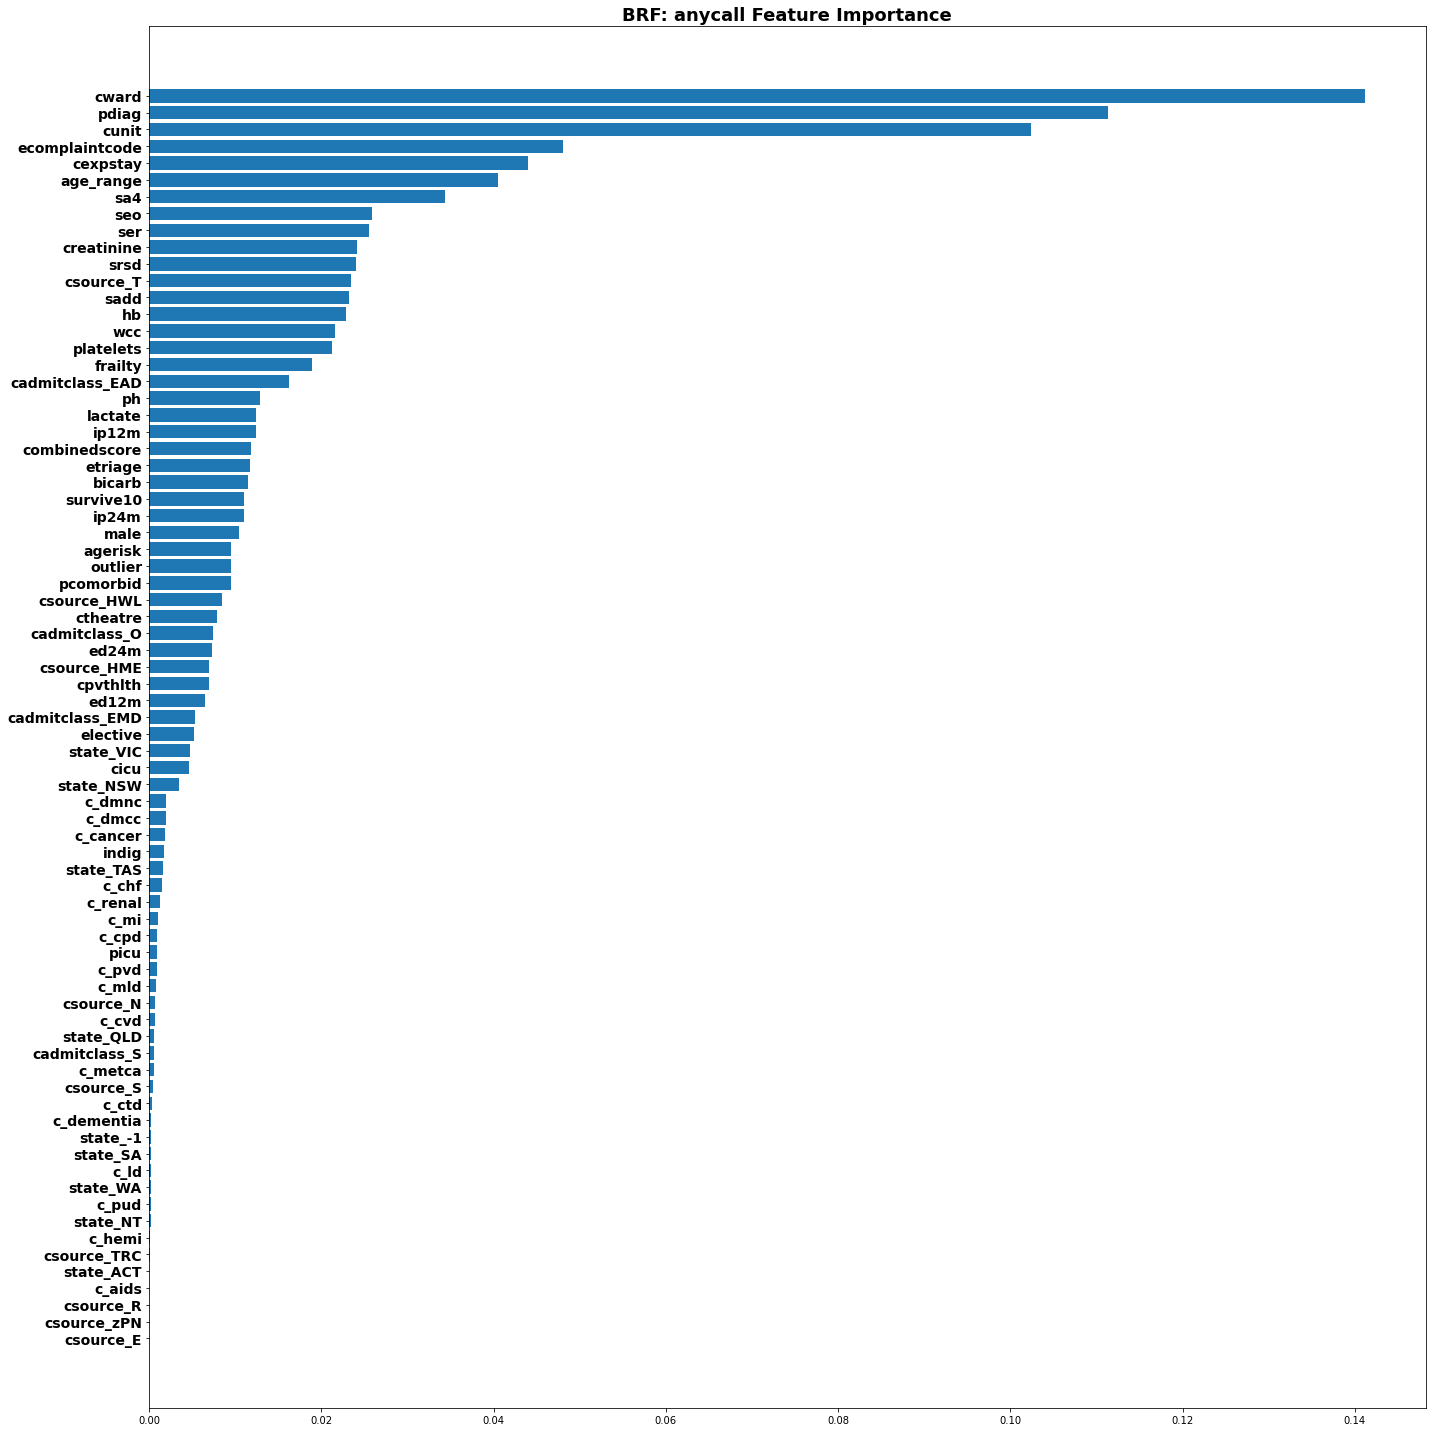

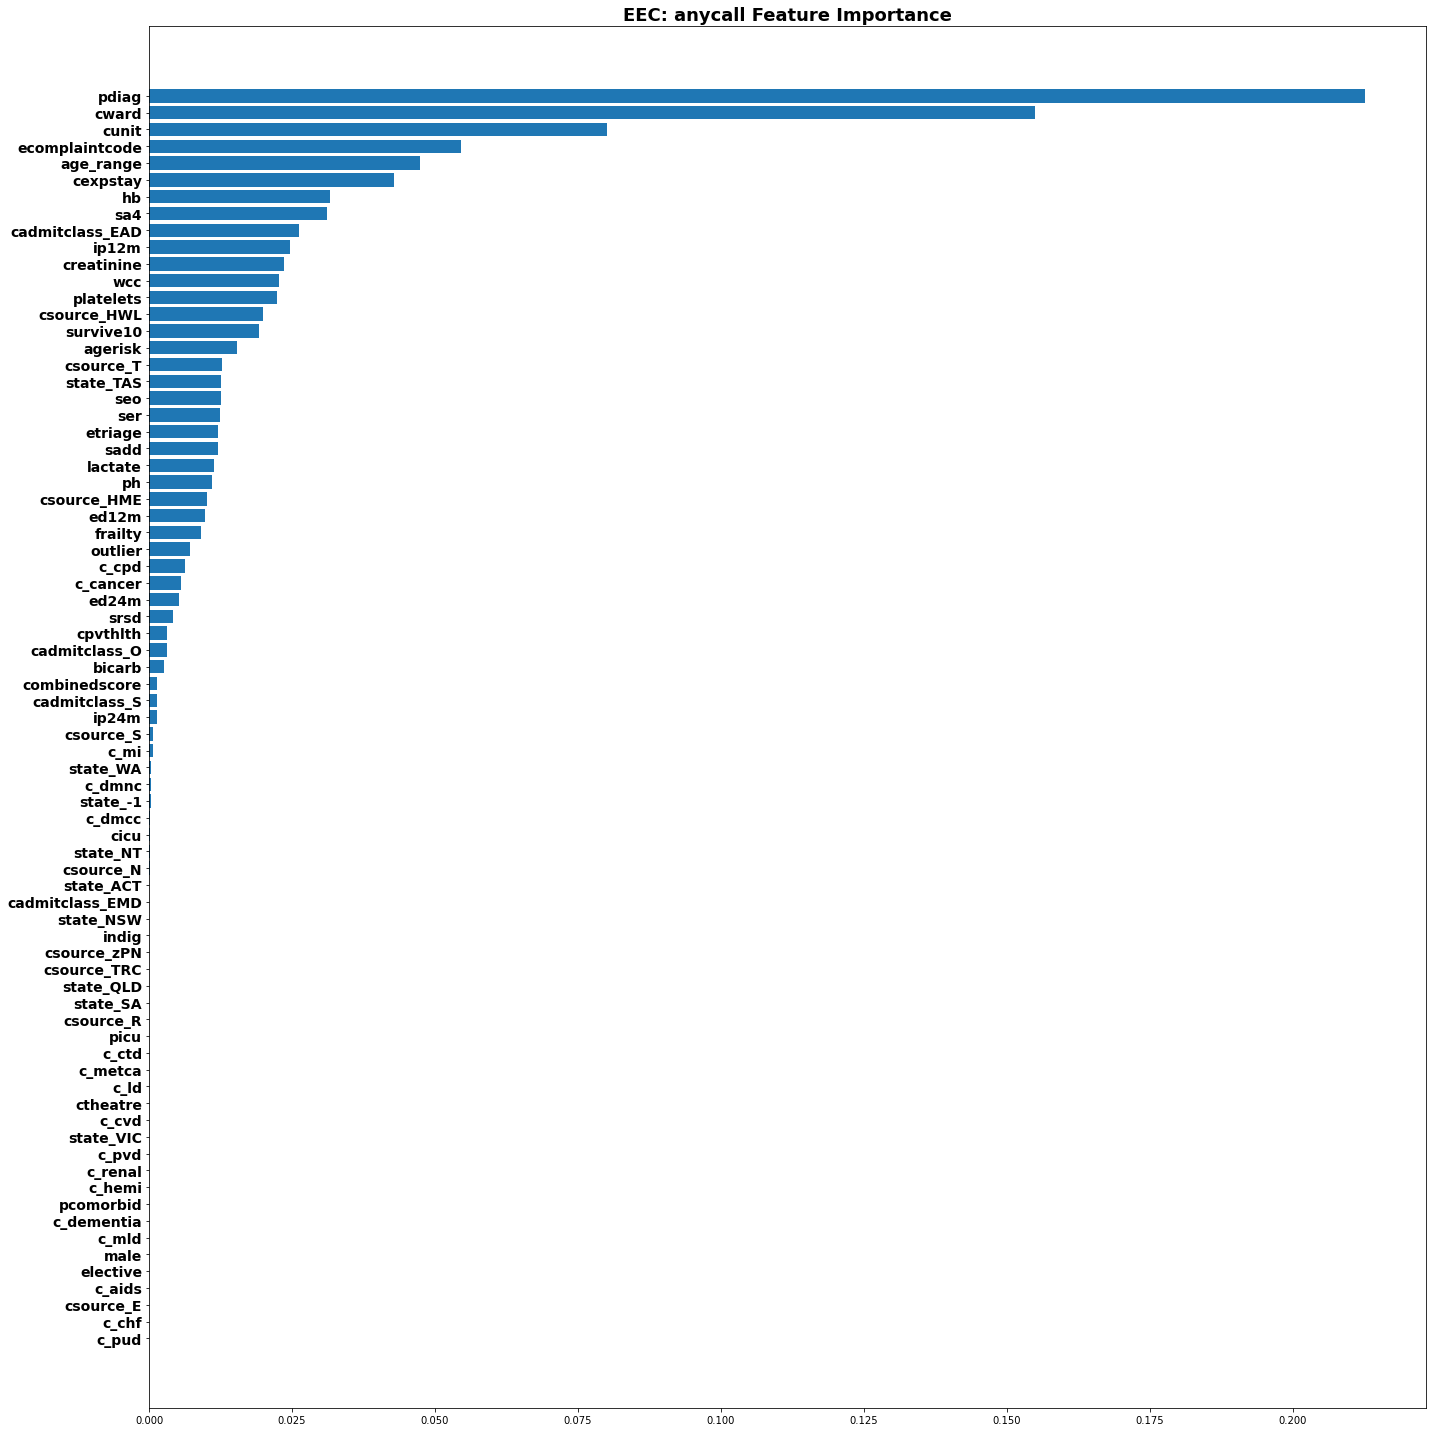

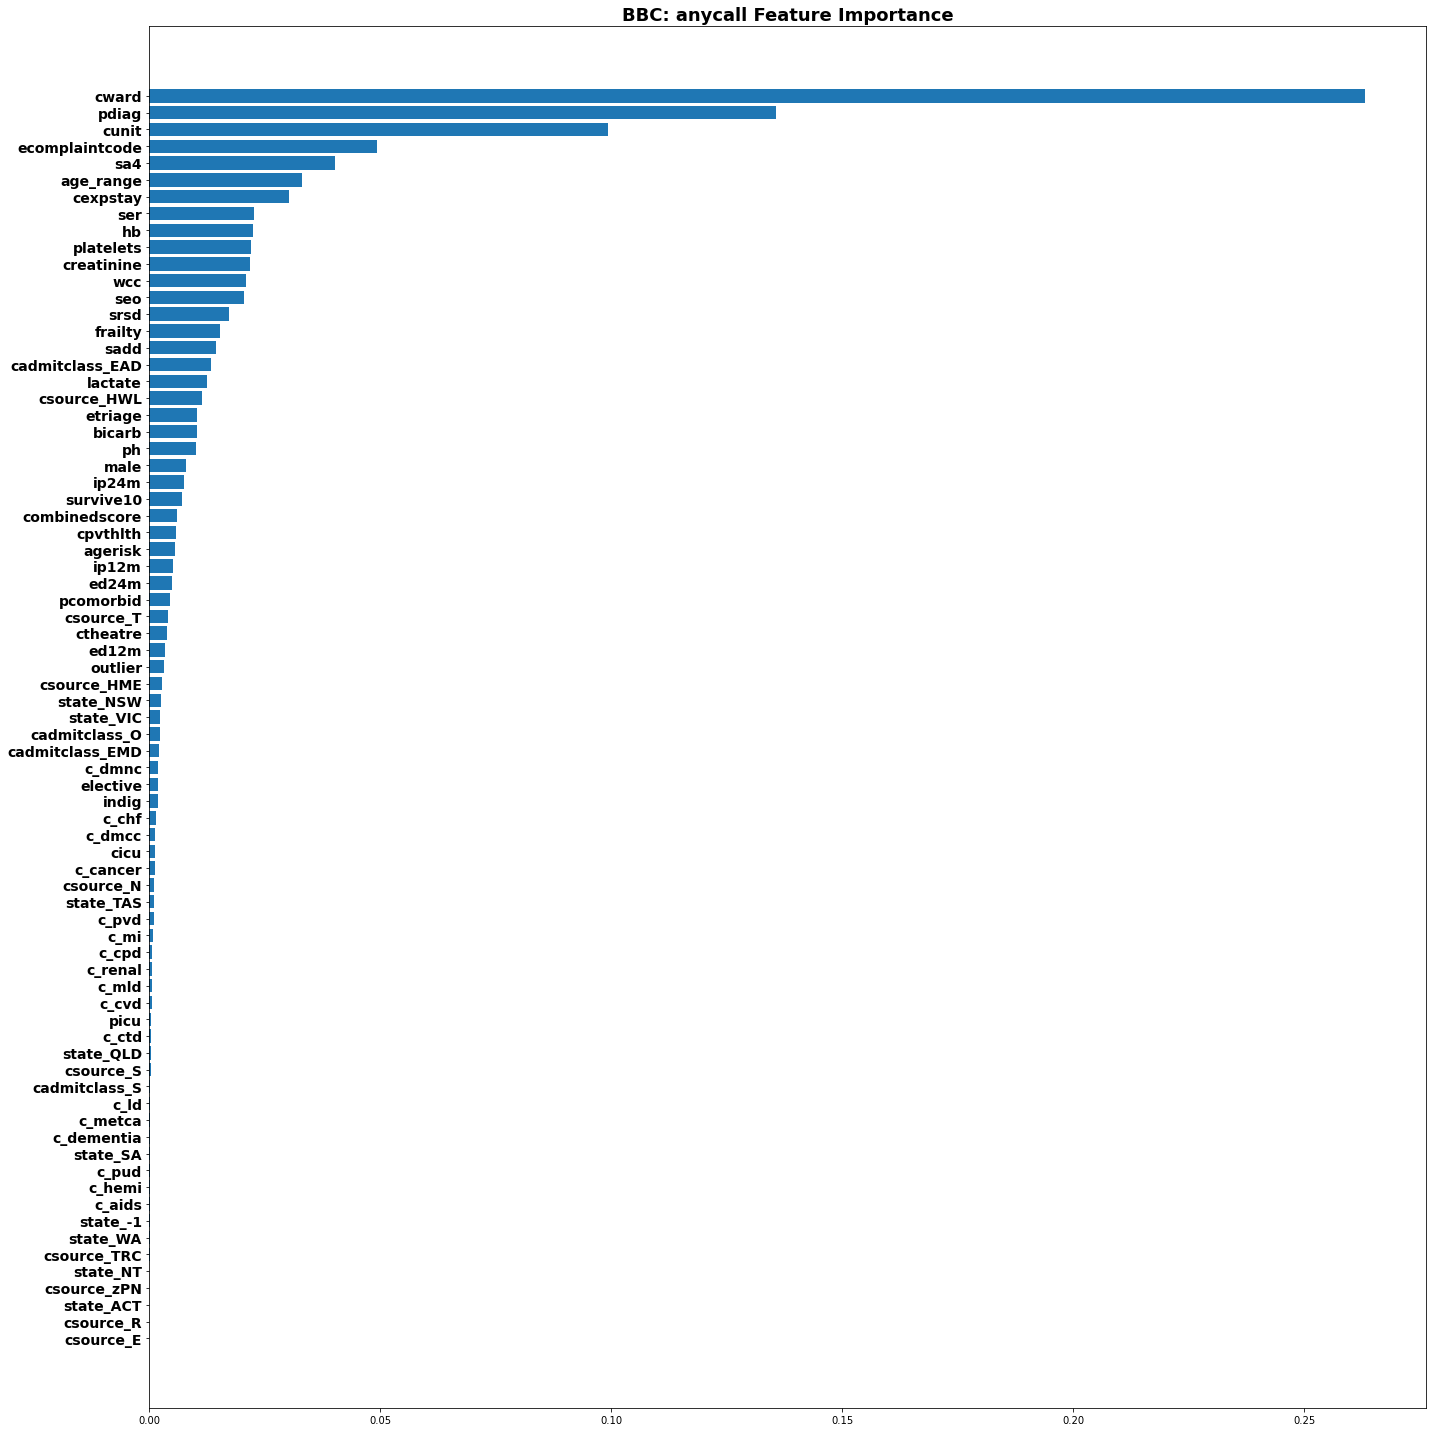

25305

In [10]:

cols = list(X_train.columns)
plt.rcParams['figure.figsize'] = (20.0, 20.0)

def plot_importance(indices, feature_importances, title):    
    sorted_idx = indices[::-1]
    feature_names = np.array(cols)[sorted_idx].tolist()
    y_ticks  = np.arange(0, len(feature_names)) 
    fig, ax = plt.subplots()
    ax.barh(y_ticks,feature_importances[sorted_idx], align='center')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names, weight = 'bold', fontsize=14)
    ax.set_title(title, weight = 'bold', fontsize=18)
    fig.tight_layout()
    #plt.savefig('Fimportance.png')
    plt.show()
    

def get_models():
    models, names = list(), list()
    
    # BRF
    models.append( BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1))
    names.append('BRF')
    # EEC
    models.append( EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)) 
    names.append('EEC')
    # BBC
    models.append( BalancedBaggingClassifier(n_estimators=100, n_jobs=-1))
    names.append('BBC')
    return models, names

indeces = []
# apply encoding on categorical features and then scale the be in standard form (zero mean and unit variance)
X_train_enc = encoder.fit_transform(X_train, y_train)

# define models
models, names = get_models()
# evaluate each model
for i in range(len(models)):
    model = models[i]
    fit = model.fit(X_train_enc, y_train)
    if names[i] == 'BRF':
        importance = -model.feature_importances_
    elif names[i] == 'BBC' or 'EEC':
        importance = -(np.mean([est.steps[1][1].feature_importances_ for est in model.estimators_], axis=0))
    indices_ = np.argsort(importance)
    selected_features_names = np.array(cols)[indices_]
    
    mv_df = pd.DataFrame({'anycall Features importance':np.array(selected_features_names)})
    #with pd.option_context('display.max_columns', None): 
    #    display(mv_df.T)
    indeces.append(indices_)
    plot_importance(indices_, -importance, names[i]+': '+target+' Feature Importance')
gc.collect()

* __Fnding 70 most voted (important) features__

In [11]:
Num_of_imp_features = 70
most_vote_dict = {k: v for v, k in enumerate(indeces[0])}

ind_list = [indeces[1], indeces[2]]
for lst in ind_list:
    for v, k in enumerate(lst):
        most_vote_dict[k] +=v

most_vote_sorted = {k: v for k, v in sorted(most_vote_dict.items(), key=lambda item: item[1])}
MV_ind = list(most_vote_sorted.keys())
mv_df = pd.DataFrame({'70 Most important features':np.array(cols)[MV_ind[:Num_of_imp_features]]})
with pd.option_context('display.max_columns', None): 
    display(mv_df.T)

# Select important features
top_70_features = list(np.array(cols)[MV_ind[:Num_of_imp_features]])

X_Train = X_train[top_70_features]
print('\nData shape: X:{}  & y:{}'.format(X_Train.shape,y_train.shape))

# handling ram usage
del  cols, Num_of_imp_features, most_vote_sorted
gc.collect()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
70 Most important features,cward,pdiag,cunit,ecomplaintcode,age_range,cexpstay,sa4,hb,creatinine,ser,wcc,platelets,seo,cadmitclass_EAD,sadd,srsd,frailty,ip12m,csource_T,lactate,etriage,csource_HWL,ph,survive10,agerisk,bicarb,combinedscore,ip24m,outlier,ed24m,csource_HME,cpvthlth,ed12m,cadmitclass_O,state_TAS,male,c_cancer,ctheatre,c_dmnc,cadmitclass_EMD,pcomorbid,state_NSW,cicu,c_cpd,c_dmcc,indig,state_VIC,c_mi,csource_N,elective,cadmitclass_S,csource_S,picu,c_chf,c_renal,c_pvd,state_QLD,c_cvd,state_-1,c_ctd,state_WA,c_mld,c_metca,state_SA,state_NT,c_ld,state_ACT,c_dementia,csource_TRC,csource_zPN



Data shape: X:(537747, 70)  & y:(537747,)


0

*  #### __TopFeature performance__

In [12]:
space = list(range(50,71,2))
# define models to test
model = Pipeline(steps=[('prep',encoder),('m',BalancedRandomForestClassifier(n_estimators=150, n_jobs=-1))])
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
scores_list = []
for ind in space:
    X = X_train[top_70_features[0:ind]]
    # evaluate the pipeline
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    scores = cross_val_score(model, X, y_train, scoring=metric, cv=cv, n_jobs=-1, error_score='raise')
    scores_list.append((ind,np.mean(scores)))
    # report pipeline performance
    print('Recall top %s: %.3f (%.3f)' % (str(ind), np.mean(scores), np.std(scores)))

# finding top feature inde
scores_array = np.array([list(item) for item in scores_list])
ind_max_score = np.argmax(scores_array[:,1])
top_feature_ind = int(scores_array[ind_max_score,0])

Recall top 50: 0.935 (0.000)
Recall top 52: 0.936 (0.003)
Recall top 54: 0.935 (0.001)
Recall top 56: 0.935 (0.001)
Recall top 58: 0.935 (0.001)
Recall top 60: 0.936 (0.003)
Recall top 62: 0.936 (0.004)
Recall top 64: 0.938 (0.000)
Recall top 66: 0.935 (0.001)
Recall top 68: 0.935 (0.003)
Recall top 70: 0.937 (0.001)


*  #### __Top Features selection__

In [13]:
X_train = X_train[top_70_features[0:top_feature_ind]]
X_test  = X_test [top_70_features[0:top_feature_ind]]

categorical_ix_new = [cat for cat in categorical_ix if cat in top_70_features]
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), categorical_ix_new )], remainder='passthrough')

In [14]:
X_train.columns

Index(['cward', 'pdiag', 'cunit', 'ecomplaintcode', 'age_range', 'cexpstay',
       'sa4', 'hb', 'creatinine', 'ser', 'wcc', 'platelets', 'seo',
       'cadmitclass_EAD', 'sadd', 'srsd', 'frailty', 'ip12m', 'csource_T',
       'lactate', 'etriage', 'csource_HWL', 'ph', 'survive10', 'agerisk',
       'bicarb', 'combinedscore', 'ip24m', 'outlier', 'ed24m', 'csource_HME',
       'cpvthlth', 'ed12m', 'cadmitclass_O', 'state_TAS', 'male', 'c_cancer',
       'ctheatre', 'c_dmnc', 'cadmitclass_EMD', 'pcomorbid', 'state_NSW',
       'cicu', 'c_cpd', 'c_dmcc', 'indig', 'state_VIC', 'c_mi', 'csource_N',
       'elective', 'cadmitclass_S', 'csource_S', 'picu', 'c_chf', 'c_renal',
       'c_pvd', 'state_QLD', 'c_cvd', 'state_-1', 'c_ctd', 'state_WA', 'c_mld',
       'c_metca', 'state_SA'],
      dtype='object')

<a class="anchor" id="heading--III"></a>
## 3. Imbalanced Classification

<a class="anchor" id="heading--3-I"></a>
### 3.1. __Model comparison__ 

In [15]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
def get_models():
    models, names = list(), list()
    
    # LR
    model_lr = LogisticRegression(C=3, solver='lbfgs', class_weight='balanced',n_jobs=-1)
    models.append(Pipeline(steps=[('prep',encoder),('t1', scaler),('m',model_lr)]))#
    names.append('LR')   
    
    # CNB
    models.append(Pipeline(steps=[('prep',encoder),('t1', scaler),('m',ComplementNB())]))#
    names.append('CNB')
    
    # RUSC (Balanced Boosting Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',RUSBoostClassifier(n_estimators=150))]))#) # 
    names.append('RUSC')      
    
    ## EEC (Balanced Boosting Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',EasyEnsembleClassifier(n_estimators=150, n_jobs=-1))]))#
    names.append('EEC')
    
    # BRF (Balanced Bagging Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',BalancedRandomForestClassifier(n_estimators=150, n_jobs=-1))]))
    names.append('BRF') 
    
    ## BBC (Balanced Bagging Ensemb model)
    models.append(Pipeline(steps=[('prep',encoder),('m',BalancedBaggingClassifier(n_estimators=150, n_jobs=-1))]))#
    names.append('BBC')
   
    
    return models, names

LR: precision: 0.06088517762357085, recall: 0.8415771937311736, auc_: 0.15901506037470708, Average precision-recall: 0.06279707227749888
CNB: precision: 0.04870283968506703, recall: 0.7430985041759606, auc_: 0.07368303359654563, Average precision-recall: 0.04313564988703296
RUSC: precision: 0.05172178173618257, recall: 0.7517397700170071, auc_: 0.0842286723614901, Average precision-recall: 0.04157582908575071
EEC: precision: 0.06507218965864943, recall: 0.8482949737296752, auc_: 0.16438518905322355, Average precision-recall: 0.06589364366756476
BRF: precision: 0.3730525957145253, recall: 0.8789631595831001, auc_: 0.8808155930064183, Average precision-recall: 0.16766906278482033
BBC: precision: 0.3850201463767401, recall: 0.8572066295072266, auc_: 0.8479037896353887, Average precision-recall: 0.22265630720719598


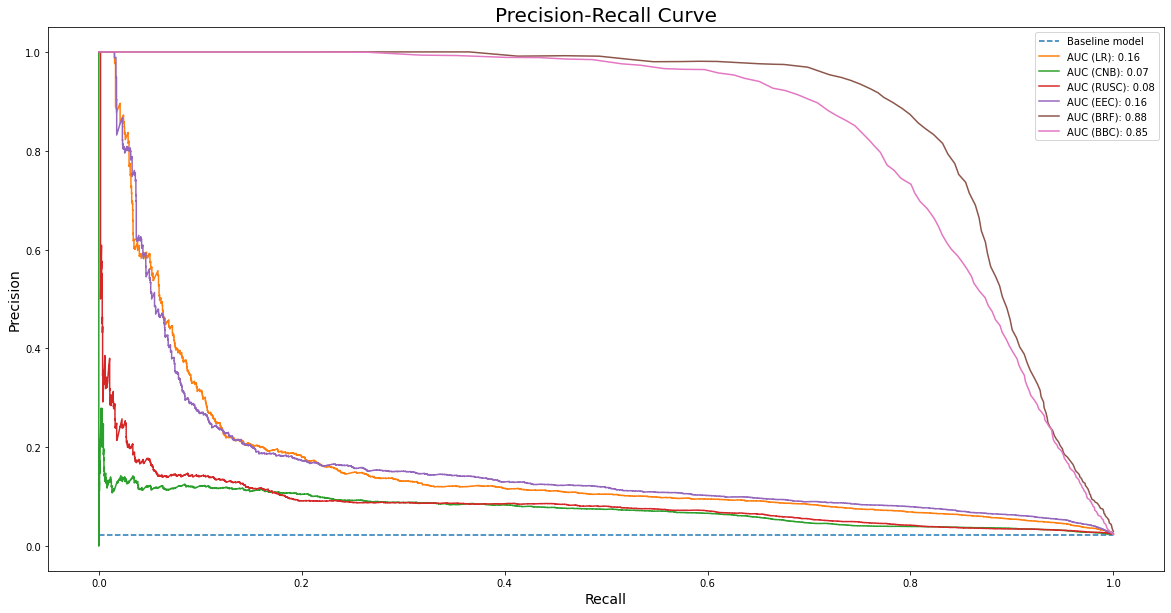

In [16]:
models, names = get_models()
results = list()
PRC_models(models, names, results,X_train, y_train, X_test, y_test)

In [17]:
#=================================
#        gridsearch
#=================================
def gc_model(X_tr , y_tr, X_tst, y_tst, model, space):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(recall_score)#sensitivity_score)
    #metric = make_scorer(fbeta_score, beta=2)
    # evaluate model
    search = GridSearchCV(estimator=model, param_grid=space, n_jobs=-1, cv=cv, scoring=metric,
                          error_score=0,verbose=5)
    search_result = search.fit(X_tr , y_tr)
    print('Training set score: ' + str(search.score(X_tr , y_tr)))
    print('Test set score: ' + str(search.score(X_tst, y_tst)))
    return search_result

def gc_models(models, names, results, spaces,X_tr , y_tr, X_tst, y_tst):
        
    # evaluate each model
    for i in range(len(models)):
        # evaluate the model and store results
        search_result = gc_model(X_tr , y_tr, X_tst, y_tst, models[i], spaces[i])
        #results.append(scores)
        # summarize and store
        print("Best of %s: %f using %s \n" % (names[i], search_result.best_score_, search_result.best_params_))

<a class="anchor" id="heading--3-II"></a>
### 3.2 __Hyperparameter Tuning__ 


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best of 0.552774 using {'model__class_weight': {1: 0.9131578947368421, 0: 0.08684210526315794}} 



<AxesSubplot:xlabel='weight'>

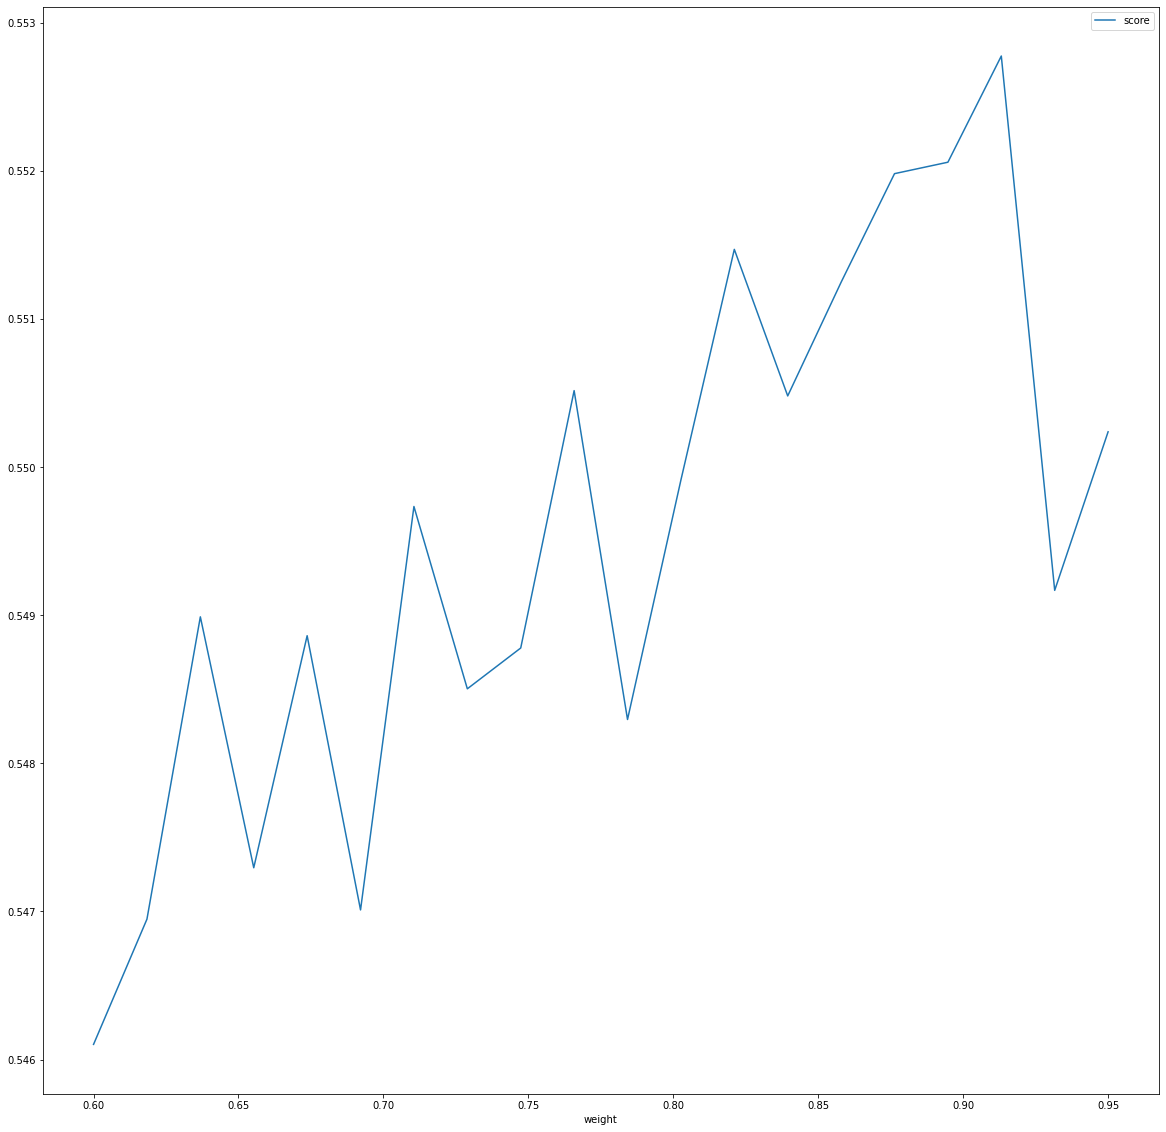

In [20]:
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics         import make_scorer

model_2 = BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1)
pipeline_brf = Pipeline(steps=[('columntransformer',encoder),('model',model_2)])

#Setting the range for class weights
weights = np.linspace(0.6, 0.95, 20)

#Creating a dictionary grid for grid search

param_grid = {'model__class_weight': [{1:x, 0:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= pipeline_brf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(n_splits=2), 
                          n_jobs=-1,                          
                          scoring=make_scorer(fbeta_score, beta=3),#'recall',  #
                          verbose=5).fit(X_train, y_train)
# save the best result
opt_class_weights = gridsearch.best_params_['model__class_weight']

print("Best of %f using %s \n" % (gridsearch.best_score_, gridsearch.best_params_))
# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [ ]:
opt_class_weights = gridsearch.best_params_['model__class_weight']
opt_class_weights

* Best model performance

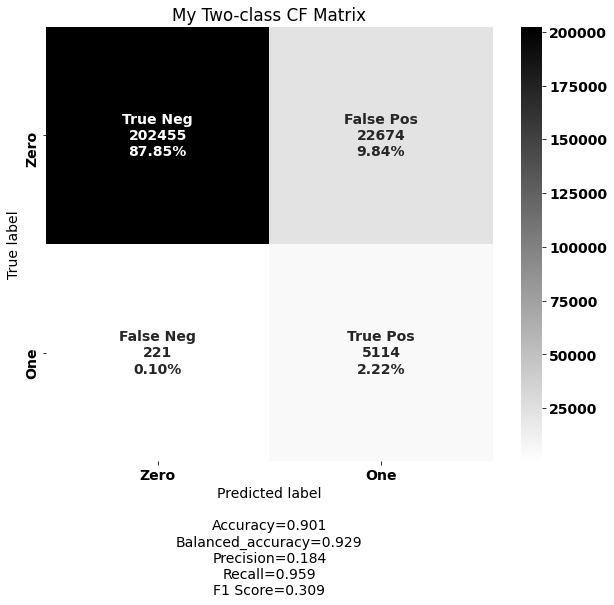

In [21]:

model_2 = BalancedRandomForestClassifier(n_estimators=500,
                                             class_weight= opt_class_weights,#{1: 0.51070031, 0: 23.8638058},#{1: 1, 0: 9},#{1: 1, 0: 5},#
                                             n_jobs=-1) 
pipe = Pipeline(steps=[('prep',encoder),('m',model_2)])


pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)

cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')

#### __Finalize Model¶__


# name of dependant variable
target = 'met'

# selected features which are the most important features for the prediction purpose
top_features    = ['cward', 'pdiag', 'cunit', 'ecomplaintcode', 'age_range', 'cexpstay',
                   'sa4', 'hb', 'creatinine', 'wcc', 'cadmitclass_EAD', 'platelets', 'seo',
                   'lactate', 'ser', 'frailty', 'csource_T', 'ip24m', 'srsd', 'sadd',
                   'survive10', 'ph', 'etriage', 'csource_HWL', 'bicarb', 'agerisk',
                   'ip12m', 'male', 'combinedscore', 'csource_HME', 'outlier', 'ed24m',
                   'ed12m', 'pcomorbid', 'cadmitclass_O', 'c_cancer', 'cicu', 'c_dmnc',
                   'ctheatre', 'cadmitclass_EMD', 'c_mi', 'c_cpd', 'cpvthlth', 'state_NSW',
                   'c_dmcc', 'state_TAS', 'state_VIC', 'indig', 'c_chf', 'csource_N',
                   'cadmitclass_S', 'elective', 'c_pvd', 'csource_S']


# preparing data for the prediction step
df_met2, categorical_ix = mimic_cleanup(df,target)

# apply feature selection besed on optimal features selected before
df_met2 = df_met2[top_features+ [target]]

# Train and test split
df_train, df_test = train_test_split(df_met2,  stratify = df_met2[target],
                                     test_size = 0.3,
                                     random_state = 42)

X_train, y_train = df_train.drop(  [target], axis=1) , df_train  [target]
X_test,  y_test  = df_test.drop([target], axis=1) , df_test[target]

# Selected encoder and scaler to be applied to the data
encoder = ColumnTransformer(transformers=[('cat', MEstimateEncoder(randomized=True), categorical_ix )], remainder='passthrough')
scaler  = MinMaxScaler()

# selecting best performing model and making the prediction pipeline
model_2 = BalancedRandomForestClassifier(n_estimators=500,
                                             class_weight= {1: 0.7842, 0: 0.2157},
                                             n_jobs=-1) 
pipe = Pipeline(steps=[('prep',encoder),('m',model_2)])

# fit the model
pipe.fit(X_train, y_train)

# Predict
predictions = pipe.predict(X_test)

# display the resutls
cf_matrix = confusion_matrix(y_test, predictions)
make_confusion_matrix(cf_matrix, group_names=CM_labels, categories=CM_categories, cmap='binary', title='My Two-class CF Matrix')